This note book deals with updated *dna24* parameter set.

# Imports

In [4]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import nupack
from nnn import train_nn as tnn
from itertools import product

# The handcrafted tloop parameters

Regress out NNN pairs on newly reprocessed data, where refseq duplicates were filtered out from the reference file before the preprocessing steps. Contains the WC ones that are also tetraloop NNN.

(16, 13)
(5096, 12)


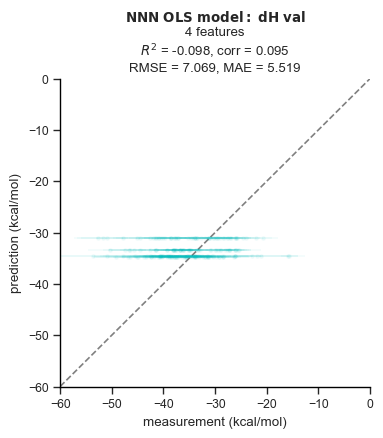

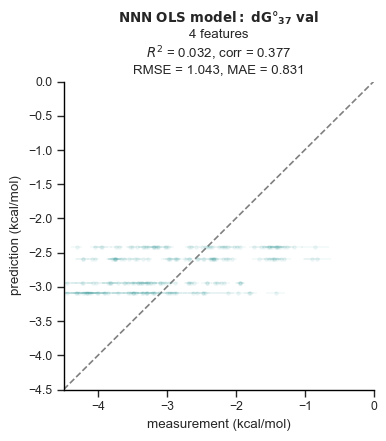

In [5]:
# All tetra and triloops, regressing NNN out.
config = dict(
    use_model_from='json',
    test_mode='test',
    secondary_struct = 'target'
)
mydata = tnn.MyData(config)
mydata.load_everything()
tloop_df = mf.regress_out_nnn_pair_tloop(mydata)

# Format tloop_df
hairpin_tloop_df = pd.DataFrame(
    dict(dH=tloop_df.groupby('tloop')['dH'].apply(np.mean),
         dG=tloop_df.groupby('tloop')['dG_37'].apply(np.mean))
)

triloop_ind = [x for x in hairpin_tloop_df.index if len(x) == 5]
tetraloop_ind = [x for x in hairpin_tloop_df.index if len(x) == 6]
hairpin_triloop_df = hairpin_tloop_df.loc[triloop_ind]
hairpin_tetraloop_df = hairpin_tloop_df.loc[tetraloop_ind]

## hairpin_triloop & hairpin_tetraloop parameters

Fill in `hairpin_triloop`, `hairpin_tetraloop`, and `hairpin_mismatch` parameters to the file `./models/dna-nnn-hploop.json`.

### json file names

In [11]:
param_set_template_file = './models/dna04.json'
param_set_hp_file = './models/dna-nnn-tloop.json'
param_set_hp_tmp_file = './models/dna-nnn-tloop-tmp.json'
param_set_hp_adj_file = './models/dna-nnn-tloop-adj.json'

### Write tloop_df values to json

In [10]:
p_ori_dict = fileio.read_json(param_set_template_file)
p_hp_dict = p_ori_dict.copy()

for p in ['dH', 'dG']:
    p_hp_dict[p]['hairpin_tetraloop'] = dict(hairpin_tetraloop_df[p])
    p_hp_dict[p]['hairpin_triloop'] = dict(hairpin_triloop_df[p])

fileio.write_json(p_hp_dict, param_set_hp_file)

### Evaluate tloop param file on training set

In [6]:
# A new version of arr_v0_1M
arr_1M = pd.read_csv('./data/models/processed/arr_v0_1M_n=30872.csv', index_col=0)

In [11]:
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]

In [83]:
%%time
val_result_df = modeling.make_model_validation_df(
    val_df,#.sample(100),
    model='nupack', 
    model_param_file=param_set_hp_file,
)

CPU times: user 24.8 s, sys: 259 ms, total: 25.1 s
Wall time: 25.2 s


In [83]:
# Save the full result (long run time)
val_result_df.to_csv('./data/models/out/train_result_dna-nnn-tloop.csv')

In [12]:
# Load the full result (long run time)
val_result_df = pd.read_csv('./data/models/out/train_result_dna-nnn-tloop.csv', index_col=0)

In [14]:
# Print the median of dH & dG offset
val_result_dict = dict()
val_result_dict['triloop'] = val_result_df.loc[[x.startswith('TRI') for x in val_result_df.index]]
val_result_dict['tetraloop'] = val_result_df.loc[[(not x.startswith('TRI')) and (not x.startswith('VAR')) for x in val_result_df.index]]

offset = dict(triloop=dict(), tetraloop=dict())

for key, df in val_result_dict.items():
    offset[key]['dH'] = np.median(val_result_dict[key].dH_pred - val_result_dict[key].dH)
    offset[key]['dG'] = np.median(val_result_dict[key].dG_37_pred - val_result_dict[key].dG_37)

print(offset)

{'triloop': {'dH': -39.386685806628634, 'dG': -0.814162875072435}, 'tetraloop': {'dH': -58.82417187815282, 'dG': -2.593613834551717}}


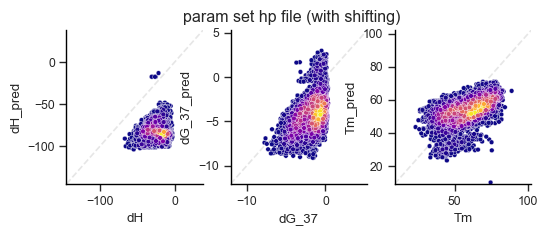

In [16]:
# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('param set hp file (with shifting)')
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df.dropna(),
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

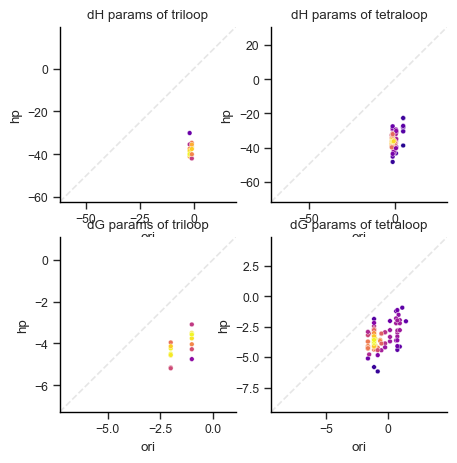

In [18]:
# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_hp_dict = fileio.read_json(param_set_hp_file)

fig, ax = plt.subplots(2,2,figsize=(5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_hp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

### Optimize the offset

In [ ]:
from scipy.optimize import minimize

def run_ddX_optimization(loop, val_df_dict, n_sample=50, n_run=5):
    def get_res_df(loss_arr, x_arr):
        res_df = pd.DataFrame(
            dict(loss=loss_arr,
             ddH=x_arr[:,0],
             ddG=x_arr[:,1]))#.sort_values(by='loss')
        return res_df

    x0 = np.array([0,0])
    loss_arr, x_arr = np.zeros(n_run), np.zeros((n_run, 2))
    for i in range(n_run):
        sampled_val_df = val_df_dict[loop].sample(n_sample)
        fun = lambda x: mupack.obj_fun_Tm_err(x, sampled_val_df=sampled_val_df, loop=loop)
        res = minimize(fun, x0, method='BFGS', tol=1e-1, options=dict(maxiter=20))
        loss_arr[i] = res.fun
        x_arr[i,:] = res.x

    res_df = get_res_df(loss_arr, x_arr)
    return res_df

In [ ]:
# Define val_df
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]

val_df_dict = dict()
val_df_dict['tetraloop'] = val_df.loc[[x.startswith('TET') for x in val_df.index]]
val_df_dict['triloop'] = val_df.loc[[x.startswith('TRI') for x in val_df.index]]

Do multiple runs of optimization on different subsampling data points, starting from 0 ddH & ddG, then take the average values and save to json.

In [ ]:
%%time
np.random.seed(42)
ddX = dict()
for loop in ['tetraloop', 'triloop']:
    res_df = run_ddX_optimization(loop, val_df_dict)
    ddX[loop] = dict(res_df.mean()[['ddH', 'ddG']])

print(ddX)
fileio.write_json(ddX, './models/ddX.json')

NameError: name 'run_ddX_optimization' is not defined

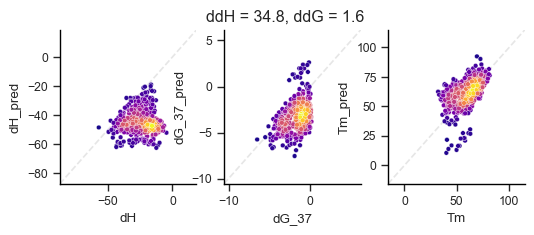

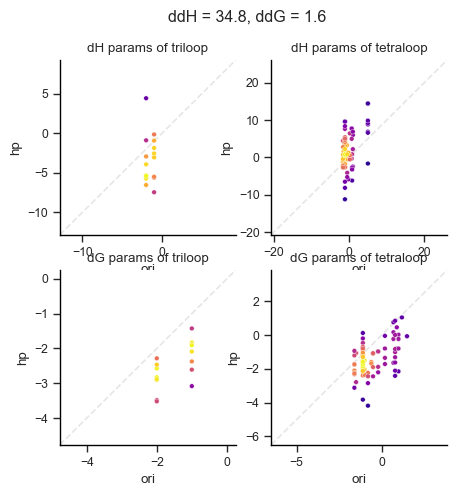

In [70]:
# Apply ddX and save to file

# Read in starting point json file
starting_p_file = './models/dna-nnn-tloop.json'
tmp_p_file = './models/dna-nnn-tloop-adj.json'
starting_p_dict = fileio.read_json(starting_p_file)

# Add new offset from `ddX`
for loop in ['tetraloop', 'triloop']:
    x_dict = ddX[loop]
    for i,p in enumerate(['dH', 'dG']):
        for k,v in starting_p_dict[p]['hairpin_'+loop].items():
            starting_p_dict[p]['hairpin_'+loop][k] = float(v + x_dict['d'+p])

# Save to temporary file
fileio.write_json(starting_p_dict, tmp_p_file)

val_df_4_test = val_df.loc[[(not x.startswith('VAR')) for x in val_df.index]].sample(500)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=tmp_p_file,
)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x[0], x[1]))
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_tmp_dict = fileio.read_json(tmp_p_file)
fig, ax = plt.subplots(2,2,figsize=(5,5))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x[0], x[1]))
for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_tmp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

### Extract hairpin_mismatch

In [73]:
# Get hairpin_mismatch params from `tmp_p_file`
tmp_p_dict = fileio.read_json(tmp_p_file)
tetloop_df = pd.DataFrame(dict(dH=tmp_p_dict['dH']['hairpin_tetraloop'], dG=tmp_p_dict['dG']['hairpin_tetraloop'])).reset_index(names=['hairpin_tetraloop'])
tetloop_df['hairpin_mismatch'] = tetloop_df['hairpin_tetraloop'].apply(lambda x: f'{x[-2]}{x[-1]}{x[0]}{x[1]}')
hpmm_df = tetloop_df.groupby('hairpin_mismatch')[['dH', 'dG']].apply(np.mean)

# Read in hairpin loop adjusted json file
hp_p_file = './models/dna-nnn-hploop.json'

# Add new offset from `ddX`
for i,p in enumerate(['dH', 'dG']):
    tmp_p_dict[p]['hairpin_mismatch'] = dict(hpmm_df[p])

# Save to hairpin param file
fileio.write_json(tmp_p_dict, hp_p_file)

# Shift one-step regression model

## Estimate weights for the objective function

<Axes: xlabel='dH_se', ylabel='Count'>

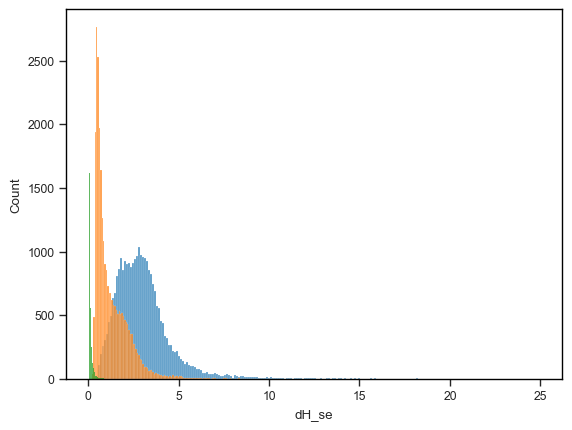

In [18]:
sns.histplot(mydata.arr.dH_se)
sns.histplot(mydata.arr.Tm_se)
sns.histplot(mydata.arr.dG_37_se)

In [21]:
get_weight = lambda x: np.mean(x)#1/np.sqrt(np.median(x))
print('w(dH)=%.2f, w(dG)=%.2f, w(Tm)=%.2f' % (get_weight(mydata.arr.dH_se), get_weight(mydata.arr.dG_37_se), get_weight(mydata.arr.Tm_se)))

w(dH)=3.09, w(dG)=0.14, w(Tm)=1.28


## Hybrid model

Use hairpin loop params from `hp_p_file = './models/dna-nnn-hploop.json'` and the rest from `swift-lake-118.json`.

In [56]:
hp_p_file = './models/dna-nnn-hploop.json'
param_set_file = './models/swift-lake-118.json'
hyb_p_file = './models/hyb.json'

p_hp_dict = fileio.read_json(hp_p_file)
p_swift_dict = fileio.read_json(param_set_file)

for p in ['dH', 'dG']:
    for loop in ['hairpin_tetraloop', 'hairpin_triloop', 'hairpin_mismatch']:
        p_swift_dict[p][loop] = mupack.update_template_dict(p_swift_dict[p][loop], p_hp_dict[p][loop])
        
fileio.write_json(p_swift_dict, hyb_p_file)

In [62]:
arr_1M = mydata.arr_1M
val_data_dict = mydata.prepare_val_df('val')

# Define val_df
inds = set(arr_1M.index) & set(mydata.data_split_dict['val_ind'])
val_df = arr_1M.loc[inds,:]

# The keys in the dictionary correspond to keys in the nupack file
val_df_dict = dict()
val_df_dict['hairpin'] = val_df.loc[[(x.startswith('TET') or x.startswith('WC') or x.startswith('TRI')) for x in val_df.index]]
val_df_dict['hairpin_triloop'] = val_df.loc[[x.startswith('TRI') for x in val_df.index]]

{'hairpin_tetraloop': {'ddH': -28.080662262625278, 'ddG': -3.9933075017714303}, 'hairpin_triloop': {'ddH': -28.080662262625278, 'ddG': -3.9933075017714303}}
CPU times: user 7min 12s, sys: 5.68 s, total: 7min 18s
Wall time: 7min 21s


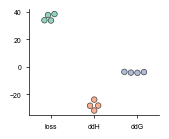

In [69]:
%%time
# Sharing ddX between tloops
param_set_file = './models/hyb.json'

ddX = dict()
res_df_dict = dict()
fig, ax = plt.subplots(figsize=(4.25*cm,3.5*cm))
loop = ['hairpin_tetraloop', 'hairpin_triloop']
res_df = mupack.run_ddX_optimization(loop, val_df_dict,
                                     n_sample = 25, n_run=4,
                                     starting_p_file = param_set_file,
                                     tmp_p_file = './models/dna-nnn-tmp.json')
sns.swarmplot(res_df, size=4, linewidth=.5, edgecolor='k', palette='Set2', alpha=.7, ax=ax)
util.beutify(ax, shrink=True, do_not_resize=True)
sns.despine()
for l in loop:
    ddX[l] = dict(res_df.median()[['ddH', 'ddG']])

util.save_fig('./fig/Fig4/ddX/ddX_swarmplot.pdf')
print(ddX)
fileio.write_json(ddX, './models/ddX_hyb.json')

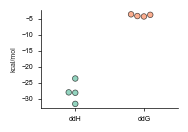

In [73]:
fig, ax = plt.subplots(figsize=(4.25*cm,3.5*cm))
sns.swarmplot(res_df[['ddH', 'ddG']], size=4, linewidth=.5, edgecolor='k', palette='Set2', alpha=.7, ax=ax)
util.beutify(ax, shrink=True, do_not_resize=True)
ax.set_ylabel('kcal/mol')
util.beutify(ax, shrink=True)
util.save_fig('./fig/Fig4/ddX/ddX_swarmplot.pdf')

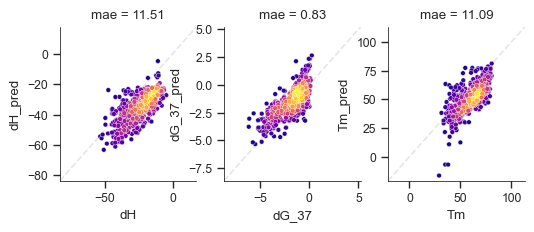

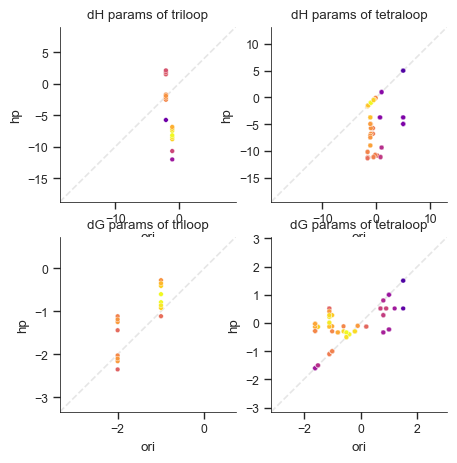

In [71]:
# Apply ddX and save to file

# Read in starting point json file
param_set_template_file = './models/dna04.json'
starting_p_file = './models/hyb.json'
tmp_p_file = './models/hyb-adj.json'

starting_p_dict = fileio.read_json(starting_p_file)
template_p_dict = fileio.read_json(param_set_template_file)

# Add new offset from `ddX`
for loop in ['hairpin_tetraloop', 'hairpin_triloop']:
    x_dict = ddX[loop]
    for i,p in enumerate(['dH', 'dG']):
        for k,v in starting_p_dict[p][loop].items():
            if mupack.is_modified(starting_p_dict[p][loop], template_p_dict[p][loop], k):
                starting_p_dict[p][loop][k] = float(v + x_dict['d'+p])

# Save to temporary file
fileio.write_json(starting_p_dict, tmp_p_file)

val_df_4_test = val_df.loc[[(not x.startswith('VAR')) for x in val_df.index]].sample(500)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=tmp_p_file,
)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))

for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    ax[i].set_title('mae = %.2f' % util.mae(val_result_df[p], val_result_df[p+'_pred']))
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_tmp_dict = fileio.read_json(tmp_p_file)
fig, ax = plt.subplots(2,2,figsize=(5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_tmp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

### Extract hairpin_mismatch

In [76]:
# Get hairpin_mismatch params from `tmp_p_file`
tmp_p_dict = fileio.read_json(tmp_p_file)
tetloop_df = pd.DataFrame(dict(dH=tmp_p_dict['dH']['hairpin_tetraloop'], dG=tmp_p_dict['dG']['hairpin_tetraloop'])).reset_index(names=['hairpin_tetraloop'])
tetloop_df['hairpin_mismatch'] = tetloop_df['hairpin_tetraloop'].apply(lambda x: f'{x[-2]}{x[-1]}{x[0]}{x[1]}')
hpmm_df = tetloop_df.groupby('hairpin_mismatch')[['dH', 'dG']].apply(np.mean)

# Read in hairpin loop adjusted json file
hp_p_file = './models/hyb-adj-ext.json'

# Add new offset from `ddX`
for i,p in enumerate(['dH', 'dG']):
    tmp_p_dict[p]['hairpin_mismatch'] = mupack.update_template_dict(tmp_p_dict[p]['hairpin_mismatch'], dict(hpmm_df[p]))

# Save to hairpin param file
fileio.write_json(tmp_p_dict, hp_p_file)